In [1]:
import pandas as pd
import scipy
import scipy.stats as st
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pinfo = pd.read_csv('../../masked/patients_info.csv', index_col=0).sort_index()
rna = pd.read_csv('../../masked/rna.csv', index_col=0)
rna = rna[rna.columns[(rna==0).mean()<0.1]]
rna = (rna+0.01).applymap(np.log2)

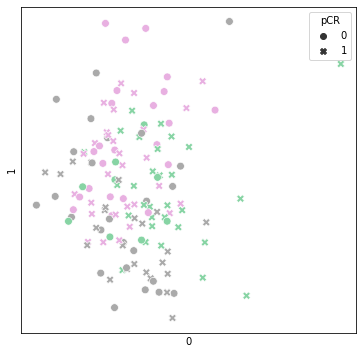

In [3]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rna_pca = pd.DataFrame(pca.fit_transform(rna))
rna_pca.index = rna.index
rna_pca['subtype'] = rna_pca.index.map(pinfo['HER2_Status'])+rna_pca.index.map(pinfo['ER_Status'])
rna_pca['pCR'] = rna_pca.index.map(pinfo['pCR'])

plt.subplots(figsize=[6,6])
sns.scatterplot(rna_pca[0],rna_pca[1],\
                c=rna_pca['subtype'].map({'PosPos':'#e8b0e1','PosNeg':'#87d4a4','NegNeg':'#aaaaaa'}),\
                style=rna_pca['pCR'], s=60)
plt.xticks([])
plt.yticks([])
plt.savefig('rna_pca.png',dpi=600)

In [4]:
df = pd.merge(pinfo[['HER2_Status','ER_Status','pCR']], rna, left_index=True, right_index=True, how='inner')
df

,HER2_Status,ER_Status,pCR,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
PS001,Pos,Neg,0,1.358703,1.759301,9.390210,2.697559,-4.614474,-1.964725,-2.834771,...,3.411483,1.463657,0.445122,2.458933,2.582580,3.743404,-2.107884,4.546408,6.290066,4.081305
PS002,Neg,Neg,0,1.994103,3.016938,8.915122,3.523211,-0.792067,1.092580,-0.474306,...,3.614042,2.307597,2.037759,3.277222,3.511368,4.562819,1.087504,3.873766,6.875901,5.295650
PS003,Pos,Pos,0,1.415224,1.777233,7.243718,0.668491,-4.292680,-4.600267,-3.117537,...,2.793015,2.106443,3.403638,1.773175,2.230959,3.148075,1.621539,3.121601,6.029015,3.968336
PS004,Neg,Neg,1,0.778341,1.740669,9.961284,1.687259,-5.361001,-2.850324,-0.657677,...,3.387435,2.320471,0.155127,2.449594,2.989072,3.902515,-3.312882,4.300179,7.280636,5.492210
PS006,Pos,Neg,1,0.906067,1.897477,9.352725,0.873105,-3.436369,-5.089857,-3.072289,...,3.360362,2.922478,3.511190,2.191764,2.436677,3.402535,0.273018,4.350472,7.109286,4.246408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS145,Neg,Neg,1,0.641515,2.311146,8.018574,2.295183,4.997197,-1.988178,-1.708118,...,3.346676,2.765935,2.680037,1.619042,2.255056,2.948047,-0.962317,3.507144,5.667254,4.119173
PS146,Neg,Neg,0,1.481135,2.284439,7.286811,2.110306,0.605584,-3.671366,-2.813814,...,3.562813,4.229968,3.524150,1.092613,1.566772,3.891396,2.184065,3.725892,5.513065,3.876251
PS147,Pos,Pos,1,1.998735,2.705478,7.618594,1.109252,2.585198,-4.724135,-3.122466,...,3.092220,3.053106,3.010082,1.535060,2.353266,3.295930,0.410733,3.582838,6.640563,3.808973
PS148,Neg,Neg,1,2.014186,2.227987,9.756146,2.317814,5.601151,-2.027810,-5.895309,...,4.232634,3.413742,4.277222,2.354347,3.057131,4.543557,-2.304441,4.998938,6.560572,4.539379


In [5]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [6]:
anova = {}

In [7]:
df_anova = df.copy()
# for i in rna.columns[(rna==np.log2(0.01)).mean()==0]:
#     df_anova[i.replace('.','_').replace('-','_')] = df[i]
#     formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
#     model = ols(formula, df_anova).fit()
#     anova[i] = anova_lm(model, typ=3)
    
# for i in rna.columns[(rna==np.log2(0.01)).mean()!=0]:
#     df_anova[i.replace('.','_').replace('-','_')] = df[i]
#     formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
#     model = ols(formula, df_anova.loc[df_anova[i]!=np.log2(0.01)]).fit()
#     anova[i] = anova_lm(model, typ=3)
    
for i in rna.columns:
    df_anova[i.replace('.','_').replace('-','_')] = df[i]
    formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
    model = ols(formula, df_anova).fit()
    anova[i] = anova_lm(model, typ=3)    

In [8]:
len(anova)

29149

In [9]:
anova_p = anova['A1BG'][[]]
for i in anova.keys():
    anova_p[i] = anova[i]['PR(>F)']

(-0.5, 11.0)

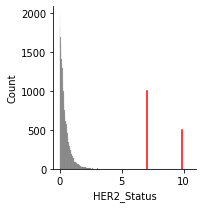

In [10]:
import numpy as np

f = 'HER2_Status'
g = 'ERBB2'

sns.displot(-anova_p.T[f].apply(np.log10), color='gray', height=3)
sns.lineplot([-anova_p.T[f].apply(np.log10)[g],-anova_p.T[f].apply(np.log10)[g]],\
             [0,1000], color='red', estimator=None)
hi = 500
for i in anova_p.T[f][anova_p.T[f]<anova_p.T[f][g]].sort_values():
    sns.lineplot([-np.log10(i),-np.log10(i)],\
                 [0,hi], color='red', estimator=None)
#     hi+=100
plt.xticks([0,5,10])
plt.xlim([-0.5,11])

(-0.5, 11.0)

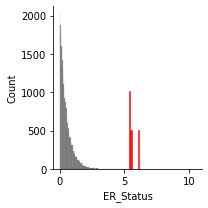

In [11]:
import numpy as np

f = 'ER_Status'
g = 'ESR1'

sns.displot(-anova_p.T[f].apply(np.log10), color='gray', height=3)
sns.lineplot([-anova_p.T[f].apply(np.log10)[g],-anova_p.T[f].apply(np.log10)[g]],\
             [0,1000], color='red', estimator=None)
hi = 500
for i in anova_p.T[f][anova_p.T[f]<anova_p.T[f][g]].sort_values():
    sns.lineplot([-np.log10(i),-np.log10(i)],\
                 [0,hi], color='red', estimator=None)
#     hi+=100
plt.xticks([0,5,10])
plt.xlim([-0.5,11])

In [12]:
anova_p.T.sort_values('HER2_Status')[:10]

,Intercept,HER2_Status,ER_Status,HER2_Status:ER_Status,pCR,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
PGAP3,1.064052e-34,1.372151e-10,0.556411,0.556411,0.772942,0.055518,0.136671,0.136671,NaN
ERBB2,1.232448e-49,9.355900e-08,0.313093,0.313093,0.457590,0.002949,0.006554,0.006554,NaN
MIEN1,2.082854e-37,2.756270e-07,0.266984,0.266984,0.831719,0.043136,0.052553,0.052553,NaN
GRB7,8.001927e-22,5.200159e-06,0.595880,0.595880,0.724249,0.208984,0.219773,0.219773,NaN
TCAP,1.688554e-03,5.265651e-06,0.639807,0.639807,0.464591,0.040971,0.020954,0.020954,NaN
HID1,4.823614e-36,5.979801e-06,0.543297,0.543297,0.831689,0.370812,0.243208,0.243208,NaN
PNMT,1.983003e-03,6.950370e-06,0.154613,0.154613,0.774999,0.366367,0.477558,0.477558,NaN
MIR4728,2.457905e-03,2.578571e-05,0.107110,0.107110,0.559150,0.047132,0.014576,0.014576,NaN
CRISP3,2.366153e-03,2.775862e-05,0.011295,0.011295,0.786298,0.647420,0.281632,0.281632,NaN
C9orf85,6.002435e-62,3.103681e-05,0.025983,0.025983,0.064450,0.052212,0.969176,0.969176,NaN


In [13]:
anova_p.T.sort_values('ER_Status')[:10]

,Intercept,HER2_Status,ER_Status,HER2_Status:ER_Status,pCR,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
C5AR2,0.068827,0.184570,6.693580e-07,6.693580e-07,0.871495,0.107102,0.053586,0.053586,NaN
AC013652.2,0.000002,0.471376,2.402409e-06,2.402409e-06,0.116059,0.105297,0.178553,0.178553,NaN
AC013652.1,0.000002,0.733717,3.224639e-06,3.224639e-06,0.477184,0.319216,0.164128,0.164128,NaN
ESR1,0.000075,0.411586,3.306739e-06,3.306739e-06,0.078944,0.952185,0.474788,0.474788,NaN
IL22RA2,0.004540,0.380898,1.110231e-05,1.110231e-05,0.948353,0.338981,0.055043,0.055043,NaN
AC074194.1,0.033837,0.115750,1.278988e-05,1.278988e-05,0.252424,0.000008,0.000009,0.000009,NaN
FSIP1,0.000022,0.618065,1.409232e-05,1.409232e-05,0.141359,0.220330,0.379292,0.379292,NaN
AMY1A,0.000638,0.532680,3.506390e-05,3.506390e-05,0.991860,0.152101,0.010567,0.010567,NaN
AC067942.1,0.338439,0.522701,3.906693e-05,3.906693e-05,0.553442,0.840147,0.942157,0.942157,NaN
CCDC170,0.001760,0.893869,4.163336e-05,4.163336e-05,0.325140,0.898578,0.554303,0.554303,NaN


In [14]:
anova_p.T.sort_values('pCR')[:10]

,Intercept,HER2_Status,ER_Status,HER2_Status:ER_Status,pCR,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
AC092349.1,6.303518e-01,0.416258,0.373484,0.373484,0.000092,0.101542,0.545737,0.545737,NaN
AP002472.1,1.272698e-02,0.091566,0.453060,0.453060,0.000176,0.017052,0.916408,0.916408,NaN
CCL20,7.785766e-04,0.984109,0.990367,0.990367,0.000357,0.092275,0.822187,0.822187,NaN
GABRD,1.726086e-03,0.695084,0.481410,0.481410,0.000357,0.008343,0.713997,0.713997,NaN
TUBGCP3,8.117374e-61,0.739026,0.540953,0.540953,0.000409,0.000280,0.019383,0.019383,NaN
MIR6505,3.136632e-01,0.942279,0.758537,0.758537,0.000468,0.817004,0.118939,0.118939,NaN
AC233702.6,3.054730e-01,0.904645,0.526342,0.526342,0.000569,0.342689,0.190361,0.190361,NaN
TRIM4,1.043781e-84,0.161345,0.775036,0.775036,0.000613,0.348603,0.185268,0.185268,NaN
FAT3,9.888326e-01,0.829254,0.665094,0.665094,0.000614,0.524830,0.336308,0.336308,NaN
AC135721.2,8.291603e-40,0.640082,0.884949,0.884949,0.000688,0.617039,0.285203,0.285203,NaN


In [15]:
anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:10]

,Intercept,HER2_Status,ER_Status,HER2_Status:ER_Status,pCR,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
AC074194.1,3.383739e-02,0.115750,0.000013,0.000013,0.252424,0.000008,0.000009,0.000009,NaN
MOB2,2.819682e-54,0.000486,0.000090,0.000090,0.377300,0.007533,0.000011,0.000011,NaN
AC007279.2,1.295319e-22,0.149557,0.011161,0.011161,0.640124,0.003918,0.000014,0.000014,NaN
KCNAB1,2.432382e-01,0.211183,0.000783,0.000783,0.205763,0.001201,0.000038,0.000038,NaN
LIPT1,2.481230e-46,0.271945,0.068159,0.068159,0.842307,0.005777,0.000046,0.000046,NaN
STOX2,4.513274e-02,0.954342,0.000751,0.000751,0.978065,0.000168,0.000058,0.000058,NaN
ZNF830,4.495115e-61,0.354215,0.081956,0.081956,0.666148,0.012651,0.000074,0.000074,NaN
FBXO25,1.448251e-34,0.446747,0.015345,0.015345,0.522468,0.002006,0.000077,0.000077,NaN
ZNF658,1.265254e-21,0.755519,0.028568,0.028568,0.570973,0.005205,0.000096,0.000096,NaN
TADA2A,2.186164e-45,0.244387,0.093660,0.093660,0.877707,0.003555,0.000112,0.000112,NaN


450


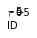

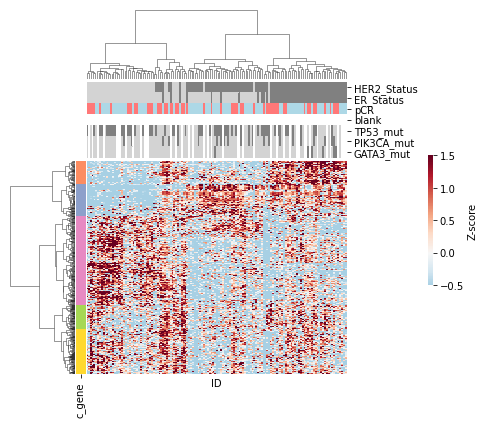

In [16]:
topN = 100
glist = []+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status')[:topN].index)+\
        list(anova_p.T.sort_values('pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status')[:topN].index)

glist = sorted(set(glist))
print(len(glist))
df_toshow = rna[glist].apply(st.zscore)
df_toshow.T.to_csv('./rna_anova100.csv')
# df_toshow['cluster'] = df_toshow.index.map(patient_cluster['x']).map(lut_c)
df_toshow['HER2_Status'] = df_toshow.index.map(pinfo['HER2_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['ER_Status'] = df_toshow.index.map(pinfo['ER_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['pCR'] = df_toshow.index.map(pinfo['pCR']).map({1:'lightblue',0:'#ff7878'})
df_toshow['blank'] = df_toshow.index.map(pinfo['pCR']).map({1:'white',0:'white'})
snv = (pd.read_csv('../../masked/snv.csv', index_col=0)>1)*1
df_toshow['TP53_mut'] = df_toshow.index.map(snv['TP53']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['PIK3CA_mut'] = df_toshow.index.map(snv['PIK3CA']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['GATA3_mut'] = df_toshow.index.map(snv['GATA3']).map({1:'gray',0:'lightgray'}).fillna('white')



lut_c = {}
for i in range(7):
    lut_c[i] = sns.color_palette("Set2")[i]
clm = sns.clustermap(df_toshow[glist].T, method='ward', metric='correlation',figsize=[0.1,0.1])                    
gene_color = df_toshow[glist].T[[]]
gene_color['c_gene'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_row.linkage, t=5, criterion='maxclust')
gene_color['c_gene'] = gene_color['c_gene'].map(lut_c)
# df['c_sample'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=6, criterion='maxclust')
# df['c_sample'] = df['c_sample'].map(lut_c)


sns.clustermap(df_toshow[glist].T,\
               col_colors=df_toshow[['HER2_Status','ER_Status','pCR','blank','TP53_mut','PIK3CA_mut','GATA3_mut']],\
                     row_colors=gene_color['c_gene'],\
               xticklabels=False,yticklabels=False,\
              row_cluster=True, col_cluster=True,method='ward',metric='correlation',\
               vmin=-.5, center=0., vmax=1.5,\
                     figsize=[6,6],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )

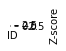

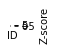

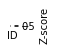

In [17]:
df_sub = {}

for i in [1,2,3]:
    df_sub[i] = df_toshow.copy()
    df_sub[i]['cluster'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=3, criterion='maxclust')
    df_sub[i] = df_sub[i][df_sub[i]['cluster']==i]

    clm_sub = sns.clustermap(df_sub[i][glist].T,\
                  row_cluster=True, col_cluster=True,method='ward',metric='correlation',\
                         figsize=[.06,.06],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )
    df_sub[i]['cluster_sub'] = scipy.cluster.hierarchy.fcluster(clm_sub.dendrogram_col.linkage, t=2, criterion='maxclust')
    df_sub[i]['cluster_sub'] = df_sub[i]['cluster'].astype(str) + df_sub[i]['cluster_sub'].astype(str)

450


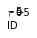

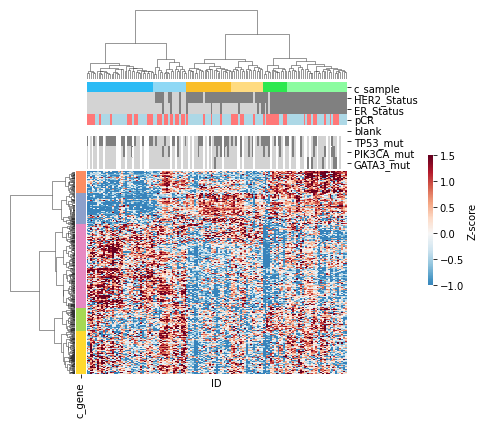

In [18]:
topN = 100
glist = []+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status')[:topN].index)+\
        list(anova_p.T.sort_values('pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status')[:topN].index)

glist = sorted(set(glist))
print(len(glist))
df_toshow = rna[glist].apply(st.zscore)
df_toshow.T.to_csv('./rna_anova100.csv')
# df_toshow['cluster'] = df_toshow.index.map(patient_cluster['x']).map(lut_c)
df_toshow['HER2_Status'] = df_toshow.index.map(pinfo['HER2_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['ER_Status'] = df_toshow.index.map(pinfo['ER_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['pCR'] = df_toshow.index.map(pinfo['pCR']).map({1:'lightblue',0:'#ff7878'})
df_toshow['blank'] = df_toshow.index.map(pinfo['pCR']).map({1:'white',0:'white'})
snv = (pd.read_csv('../../masked/snv.csv', index_col=0)>1)*1
df_toshow['TP53_mut'] = df_toshow.index.map(snv['TP53']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['PIK3CA_mut'] = df_toshow.index.map(snv['PIK3CA']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['GATA3_mut'] = df_toshow.index.map(snv['GATA3']).map({1:'gray',0:'lightgray'}).fillna('white')



lut_c = {}
for i in range(7):
    lut_c[i] = sns.color_palette("Set2")[i]
clm = sns.clustermap(df_toshow[glist].T, method='ward', metric='correlation',figsize=[0.1,0.1])                    
gene_color = df_toshow[glist].T[[]]
gene_color['c_gene'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_row.linkage, t=5, criterion='maxclust')
gene_color['c_gene'] = gene_color['c_gene'].map(lut_c)


# df['c_sample'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=6, criterion='maxclust')
df_toshow['c_sample'] = df_toshow.index.map(pd.concat([df_sub[1][['cluster_sub']],df_sub[2][['cluster_sub']],df_sub[3][['cluster_sub']]])['cluster_sub'])
df_toshow['c_sample'] = df_toshow['c_sample'].map({'11':'#2abbf5','12':'#8ed8f5','21':'#fabe28','22':'#ffdb80','31':'#2ce84f','32':'#8bfca0'})


sns.clustermap(df_toshow[glist].T,\
               col_colors=df_toshow[['c_sample','HER2_Status','ER_Status','pCR','blank','TP53_mut','PIK3CA_mut','GATA3_mut']],\
                     row_colors=gene_color['c_gene'],\
               xticklabels=False,yticklabels=False,\
              row_cluster=True, col_cluster=True,method='ward',metric='correlation',\
               vmin=-1., center=0, vmax=1.5,\
                     figsize=[6,6],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )
plt.savefig('rna.100.png',dpi=600)

In [19]:
i='all'
df_sub[i] = df_toshow.copy()
df_sub[i]['cluster'] = df_toshow.index.map(pd.concat([df_sub[1][['cluster_sub']],df_sub[2][['cluster_sub']],df_sub[3][['cluster_sub']]])['cluster_sub'])#
df_sub[i]['cluster'] = df_sub[i]['cluster'].apply(lambda x:x[:1])
print(st.chi2_contingency(pd.crosstab([df_sub[i]['HER2_Status'],df_sub[i]['ER_Status']], df_sub[i]['cluster'],)))
pd.crosstab([df_sub[i]['HER2_Status'],df_sub[i]['ER_Status']], df_sub[i]['cluster'],)

(182.82531906515646, 1.8438171824603656e-38, 4, array([[20.05714286, 15.22857143, 16.71428571],
       [15.04285714, 11.42142857, 12.53571429],
       [18.9       , 14.35      , 15.75      ]]))


cluster                 1   2   3
HER2_Status ER_Status            
gray        gray        3   6  43
            lightgray   5  33   1
lightgray   lightgray  46   2   1

In [20]:
i='all'
df_sub[i] = df_toshow.copy()
df_sub[i]['cluster'] = df_toshow.index.map(pd.concat([df_sub[1][['cluster_sub']],df_sub[2][['cluster_sub']],df_sub[3][['cluster_sub']]])['cluster_sub'])#
# df_sub[i]['cluster'] = df_sub[i]['cluster'].apply(lambda x:x[:1])
print(st.chi2_contingency(pd.crosstab([df_sub[i]['pCR']], df_sub[i]['cluster'],)))
pd.crosstab([df_sub[i]['pCR']], df_sub[i]['cluster'],)

(17.115952364935914, 0.004285059786448718, 5, array([[14.65714286,  7.32857143,  9.77142857,  6.92142857,  5.29285714,
        13.02857143],
       [21.34285714, 10.67142857, 14.22857143, 10.07857143,  7.70714286,
        18.97142857]]))


cluster,11,12,21,22,31,32
pCR,,,,,,
#ff7878,15,11,4,7,10,10
lightblue,21,7,20,10,3,22


In [21]:
i='all'
df_sub[i] = df_toshow.copy()
df_sub[i]['cluster'] = df_toshow.index.map(pd.concat([df_sub[1][['cluster_sub']],df_sub[2][['cluster_sub']],df_sub[3][['cluster_sub']]])['cluster_sub'])#
df_sub[i]['cluster'] = df_sub[i]['cluster'].apply(lambda x:x[:1])
print(st.chi2_contingency(pd.crosstab([df_sub[i]['pCR']], df_sub[i]['cluster'],)))
pd.crosstab([df_sub[i]['pCR']], df_sub[i]['cluster'],)

(4.770468743227558, 0.09206739906555464, 2, array([[21.98571429, 16.69285714, 18.32142857],
       [32.01428571, 24.30714286, 26.67857143]]))


cluster,1,2,3
pCR,,,
#ff7878,26,11,20
lightblue,28,30,25
